In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from decimal import Decimal
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_table('~/Documents/video-qoe-labeling/data.txt', delim_whitespace=True, dtype = {'BitRate': np.float64, 'FreezeRatio': np.float64, 'Quality': np.int32})

In [3]:
df['BitRate'] = df['BitRate']/100

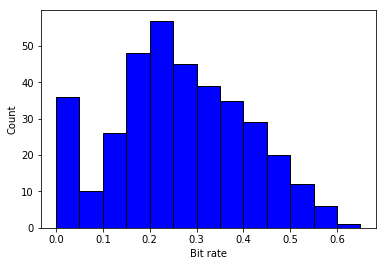

In [4]:
plt.hist(df['BitRate'], bins = [0.05*x for x in range(14)],facecolor='blue', edgecolor = 'black')
plt.xlabel('Bit rate')
plt.ylabel('Count')
plt.show()

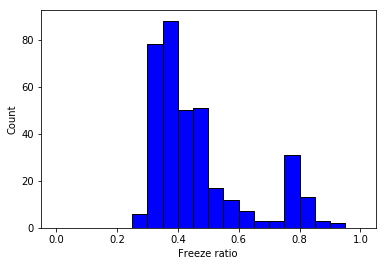

In [5]:
plt.hist(df['FreezeRatio'], bins = [0.05*x for x in range(21)],facecolor='blue', edgecolor = 'black')
plt.xlabel('Freeze ratio')
plt.ylabel('Count')
plt.show()

In [6]:
# get (X, y) and set fold
X, y = np.array(df[['BitRate', 'FreezeRatio']]), np.array(df['Quality'])
accuracies = {}
confusion = {}
fold = 10

In [7]:
# function for performing k-fold cross validation 
def k_Fold_CV(classifier, n):
    accuracies = []
    confusion = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        pred = classifier.fit(X[train], y[train]).predict(X[test])
        accuracies.append(classifier.score(X[test], y[test]))
        confusion.append(confusion_matrix(y[test], pred))
    return (accuracies, confusion)

In [8]:
# random forest
params = {'n_estimators': range(1, 21), 'criterion': ('gini', 'entropy')}
clf = GridSearchCV(RandomForestClassifier(random_state = 1), params)
clf.fit(X, y)
print("Best estimator: ", clf.best_estimator_)
print("Accuracies: {0:.3f}".format(clf.best_score_))

Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
Accuracies: 0.775


In [9]:
# Grid search found the best estimator to be n_estimators = 13 using gini index 
classifier = RandomForestClassifier(n_estimators = 13, criterion = 'gini', random_state = 1)
accuracies['random_forest'], confusion['random_forest'] = k_Fold_CV(classifier, fold)

In [10]:
# k nearest neighbors
params = {'n_neighbors':range(1, 11)}
clf = GridSearchCV(KNeighborsClassifier(), params)
clf.fit(X, y)
print("Best estimator: ", clf.best_estimator_)
print("Accuracies: {0:.3f}".format(clf.best_score_))

Best estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
Accuracies: 0.813


In [11]:
# best estimator is n_neighbors = 9 found by grid search
accuracies['nearest_neighbor'], confusion['nearest_neighbor'] = k_Fold_CV(KNeighborsClassifier(n_neighbors = 9), fold)

In [12]:
# Naive Bayes classifier
accuracies['naive_bayers'], confusion['naive_bayers'] = k_Fold_CV(GaussianNB(), fold)

In [13]:
# SVM classfier
params = {'kernel':('poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10]}
clf = GridSearchCV(SVC(random_state = 12345), params)
clf.fit(X, y)
print("Best estimator: ", clf.best_estimator_)
print("Accuracies: {0:.3f}".format(clf.best_score_))

Best estimator:  SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=12345, shrinking=True,
  tol=0.001, verbose=False)
Accuracies: 0.764


In [14]:
# best estimator is C = 10, kernel = 'rbf' by grid search
accuracies['svm'], confusion['svm'] = k_Fold_CV(SVC(C = 10, kernel = 'rbf'), fold)

In [15]:
for k, v in accuracies.items():
    print(k)
    print("{}_fold accuracies: ".format(fold), np.around(v, decimals = 3))
    print("Average accuracy: {0:0.3f}".format(np.mean(v)))
    print("#################################")

random_forest
10_fold accuracies:  [ 0.757  0.865  0.784  0.865  0.889  0.972  0.75   0.694  0.75   0.833]
Average accuracy: 0.816
#################################
nearest_neighbor
10_fold accuracies:  [ 0.811  0.838  0.757  0.838  0.889  0.972  0.778  0.778  0.639  0.833]
Average accuracy: 0.813
#################################
naive_bayers
10_fold accuracies:  [ 0.946  0.811  0.784  0.73   0.806  0.944  0.806  0.778  0.694  0.75 ]
Average accuracy: 0.805
#################################
svm
10_fold accuracies:  [ 0.892  0.865  0.784  0.838  0.861  0.972  0.75   0.694  0.667  0.861]
Average accuracy: 0.818
#################################


In [19]:
# binarize labels
labels = range(3)
y_bin = label_binarize(y, classes = labels)

# function for computing the ROC curves in k-fold CV
def k_Fold_roc(classifier, n, labels):
    aucs = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        y_score = ovr(classifier).fit(X[train], y_bin[train]).predict_proba(X[test])
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(len(labels)):
            fpr[i], tpr[i], _ = roc_curve(y_bin[test][:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        aucs.append(roc_auc)
    return aucs 

In [20]:
fold = 10
aucs = {}
classifiers = {'random_forest': RandomForestClassifier(n_estimators = 13, random_state = 1), 
               'nearest_neighbor': KNeighborsClassifier(n_neighbors = 9),
               'naive_bayers': GaussianNB(),
               'svm': SVC(C = 10, kernel = 'rbf', probability = True)}
for k, v in classifiers.items():
    aucs[k] = k_Fold_roc(v, fold, labels)

In [21]:
for k, v in aucs.items():  # v is a list of dictionaries
    print(k)
    print("{}_fold AUCs: ".format(fold))
    for x in v:  # x is a dictionary {'label': AUC}
        print({l:'{0:5.3f}'.format(x[l]) for l in x.keys()})
    print("#################################")

random_forest
10_fold AUCs: 
{0: '1.000', 1: '0.843', 2: '0.905'}
{0: '0.974', 1: '0.869', 2: '0.904'}
{0: '1.000', 1: '0.915', 2: '0.904'}
{0: '0.967', 1: '0.820', 2: '0.933'}
{0: '0.957', 1: '0.900', 2: '0.977'}
{0: '0.973', 1: '1.000', 2: '0.962'}
{0: '0.968', 1: '0.844', 2: '0.883'}
{0: '1.000', 1: '0.846', 2: '0.819'}
{0: '1.000', 1: '0.769', 2: '0.805'}
{0: '1.000', 1: '0.862', 2: '0.907'}
#################################
nearest_neighbor
10_fold AUCs: 
{0: '1.000', 1: '0.880', 2: '0.939'}
{0: '0.976', 1: '0.902', 2: '0.969'}
{0: '0.997', 1: '0.908', 2: '0.952'}
{0: '0.991', 1: '0.913', 2: '0.972'}
{0: '0.958', 1: '0.921', 2: '0.969'}
{0: '1.000', 1: '1.000', 2: '0.960'}
{0: '0.957', 1: '0.831', 2: '0.917'}
{0: '1.000', 1: '0.924', 2: '0.908'}
{0: '1.000', 1: '0.796', 2: '0.805'}
{0: '1.000', 1: '0.842', 2: '0.890'}
#################################
naive_bayers
10_fold AUCs: 
{0: '1.000', 1: '0.439', 2: '0.939'}
{0: '0.985', 1: '0.413', 2: '0.978'}
{0: '1.000', 1: '0.513', 2: '

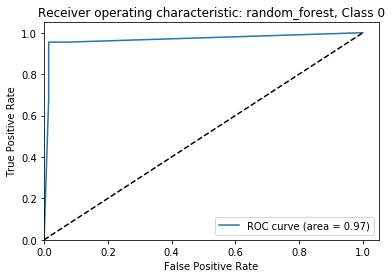

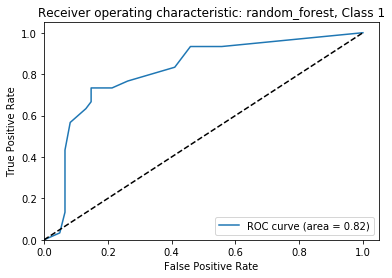

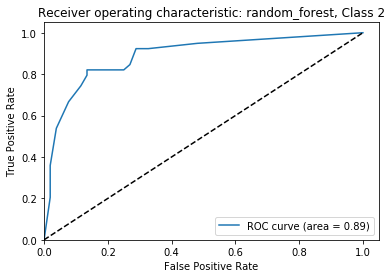

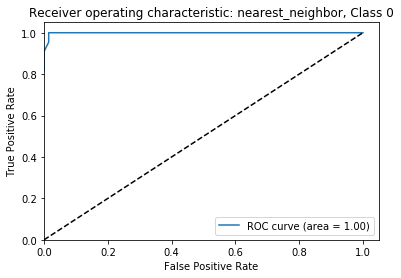

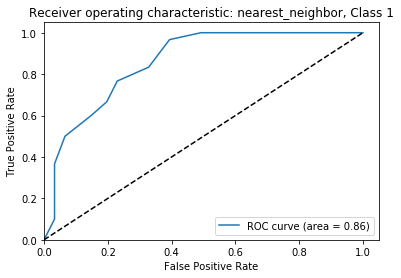

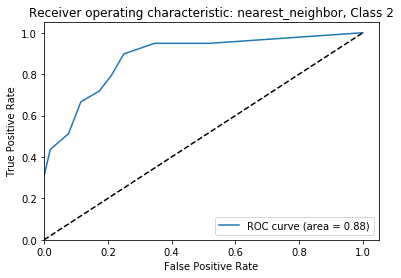

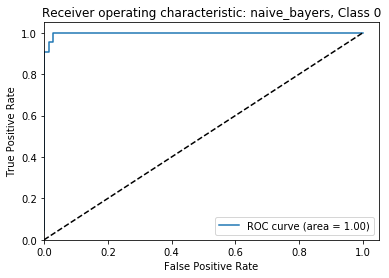

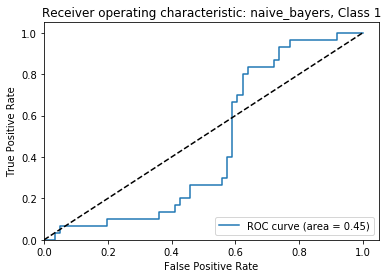

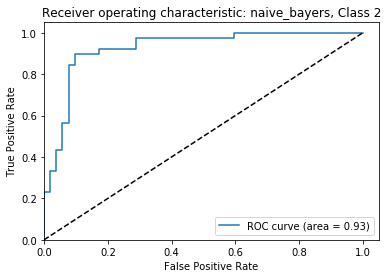

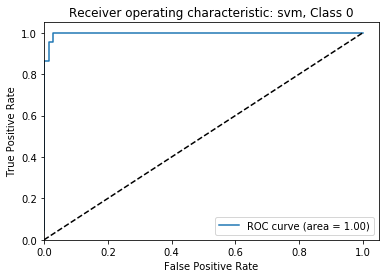

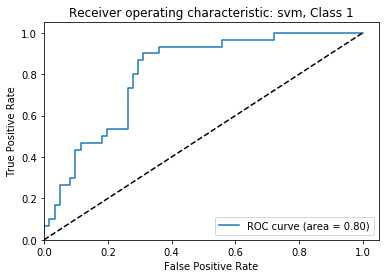

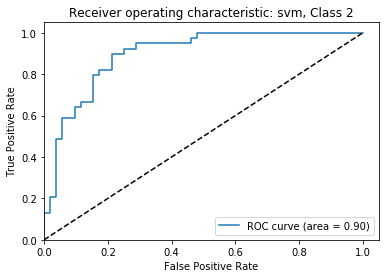

In [31]:
# ROC curves
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.25, random_state = 0)
  
def plot_roc(fpr, tpr, roc_auc, clf_name, label):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: {}, Class {}'.format(clf_name, label))
    plt.legend(loc="lower right")
    plt.show()
        
fpr = {}
tpr = {}
roc_auc = {}
        
for c, C in classifiers.items():
    y_score = ovr(C).fit(X_train, y_train).predict_proba(X_test)
    fpr[c] = {}
    tpr[c] = {}
    roc_auc[c] = {}
    for i in range(len(labels)):
        fpr[c][i], tpr[c][i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[c][i] = auc(fpr[c][i], tpr[c][i])
        plot_roc(fpr[c][i], tpr[c][i], roc_auc[c][i], c, i)
        